## Transformer Translator

데이터들은 교재에 있던 부분과 동일하게 가져가자.
논문 설명을 최대한 따라가보자.

In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import torch
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# 이번 실습에서는 약 19만개의 데이터 중 33,000개의 샘플만을 사용할 예정이다.
num_samples = 33000

# fra-eng.zip 파일을 다운로드하고 압축을 풀자
!wget -c http://www.manythings.org/anki/fra-eng.zip && unzip -o fra-eng.zip

'''
전처리 함수들을 구현
구두점 등을 제거하거나 단어와 구분해주기 위한 전처리
'''
def unicode_to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
  # 악센트 삭제 함수 호출
  sent = unicode_to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백을 만든다.
  # Ex) "he is a boy." -> "he is a boy ."
  sent = re.sub(r"([?.!,¿])",r" \1",sent)

  # (a-z,A-Z,".","?","!",",") 이들을 제외하고는 전부 공백으로 변환한다.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ",sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+"," ",sent)
  return sent

def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt","r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split("\t")

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break
  return encoder_input, decoder_input, decoder_target

# 구현한 전처리 함수들을 임의의 문장을 입력으로 테스트
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 : ', en_sent)
print('전처리 후 영어 문장 : ', preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 : ', preprocess_sentence(fr_sent))

'''
전체 데이터에서 33,000개의 샘플에 대해서 전처리 수행
또한 훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이므로,
훈련 시 사용할 디코더의 입력 시퀀스와 실제 값, 즉 레이블에 해당되는 출력 시쿼스를
따로 분리하여 저장
입력 시퀀스에는 시작을 의미하는 토큰인 <sos>를 추가하고
출력 시퀀스에는 종료를 의미하는 토큰인 <eos>를 추가함
이렇게 얻은 3개의 데이터셋 인코더의 입력, 디코더의 입력, 디코더의 레이블을
상위 5개 샘플만 출력
'''
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 : ', sents_en_in[:5])
print('디코더의 입력 : ', sents_fra_in[:5])
print('디코더의 레이블 : ', sents_fra_out[:5])

--2025-09-12 14:05:43--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8143096 (7.8M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.77M  8.11MB/s    in 1.0s    

2025-09-12 14:05:45 (8.11 MB/s) - ‘fra-eng.zip’ saved [8143096/8143096]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
전처리 전 영어 문장 :  Have you had dinner?
전처리 후 영어 문장 :  have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 :  avez vous deja dine ?
인코더의 입력 :  [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 :  [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 :  [['va', '!', '<eos>'], ['marche'

In [ ]:
def build_vocab(sents):
  word_list = []

  for sent in sents:
    for word in sent:
      word_list.append(word)

  # 각 단어별 등장 빈도를 계산하여 등장 빈도가 높은 순서로 정렬
  word_counts = Counter(word_list)
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # 등장 빈도가 높은 단어일수록 낮은 정수를 부여
  for index, word in enumerate(vocab):
    word_to_index[word] = index + 2

  return word_to_index

'''
영어를 위한 단어 집합 src_vocab과 프랑스어를 이용한 단어 집합
tar_vocab를 만들어보자.
구현 방식에 따라서는 하나의 단어 집합으로 만들어도 상관 없으며 이는 선택의 차이이다.
'''
src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fra_in + sents_fra_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print('영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}'.format(src_vocab_size, tar_vocab_size))

'''
정수로부터 단어를 얻는 딕셔너리를 각각 만들어줌
이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용됨
'''
index_to_src = {v : k for k, v in src_vocab.items()}
index_to_tar = {v : k for k, v in tar_vocab.items()}

def texts_to_sequences(sents, word_to_index):
  encoded_X_data = []
  for sent in tqdm(sents):
    index_sequences = []
    for word in sent:
      try:
        index_sequences.append(word_to_index[word])
      except KeyError:
        index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fra_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fra_out, tar_vocab)

# 상위 5개의 샘플에 대해서 정수 인코딩 전, 후 문장 출력
# 인코더 입력이므로 <sos>나 <eos>가 없음
for i, (item1, item2) in zip(range(5), zip(sents_en_in, encoder_input)):
  print(f"index : {i}, 정수 인코딩 전 : {item1}, 정수 인코딩 후 : {item2}")

def pad_sequences(sentences, max_len=None):
  # 최대 길이 값이 주어지지 않을 경우 데이터 내 최대 길이로 패딩
  if max_len is None:
    max_len = max([len(sentence) for sentence in sentences])

  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)

# 데이터의 크기(shape)을 확인하자
print('인코더의 입력의 크기(shape) : ', encoder_input.shape)
print('디코더의 입력의 크기(shape)', decoder_input.shape)
print('디코더의 레이블의 크기(shape)', decoder_target.shape)

'''
테스트 데이터를 분리하기 전 데이터를 섞어준다.
이를 위해서 순서가 섞인 정수 시퀀스 리스트를 만든다.
'''
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 : ', indices)

# 이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞이데 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

'''
임의로 30,997번째 샘플을 출력해보자
이 때 decoder_input과 decoder_target은 데이터의 구조상으로
앞에 붙은 <sos> 토큰과 뒤에 붙은 <eos> 을 제외하면 동일한 시퀀스를 가져야 함
'''
print([index_to_src[word] for word in encoder_input[30997]])
print([index_to_tar[word] for word in decoder_input[30997]])
print([index_to_tar[word] for word in decoder_target[30997]])

# 33,000개의 10% 에 해당되는 3,300개의 데이터를 테스트 데이터로 사용
n_of_val = int(33000 * 0.1)
print('검증 데이터의 개수 : ', n_of_val)

# 데이터에서 앞부분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# 데이터에서 뒷부분
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 훈련 데이터와 테스트 데이터의 크기(shape)를 출력해보자
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

영어 단어 집합의 크기 : 4498, 프랑스어 단어 집합의 크기 : 7895


100%|██████████| 33000/33000 [00:00<00:00, 654637.79it/s]


index : 0, 정수 인코딩 전 : ['go', '.'], 정수 인코딩 후 : [27, 2]
index : 1, 정수 인코딩 전 : ['go', '.'], 정수 인코딩 후 : [27, 2]
index : 2, 정수 인코딩 전 : ['go', '.'], 정수 인코딩 후 : [27, 2]
index : 3, 정수 인코딩 전 : ['go', '.'], 정수 인코딩 후 : [27, 2]
index : 4, 정수 인코딩 전 : ['hi', '.'], 정수 인코딩 후 : [740, 2]
인코더의 입력의 크기(shape) :  (33000, 7)
디코더의 입력의 크기(shape) (33000, 16)
디코더의 레이블의 크기(shape) (33000, 16)
랜덤 시퀀스 :  [15198 12924 31169 ... 10692 15963 16863]
['try', 'this', 'instead', '.', '<PAD>', '<PAD>', '<PAD>']
['<sos>', 'essayez', 'plutot', 'ceci', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['essayez', 'plutot', 'ceci', '.', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
검증 데이터의 개수 :  3300
훈련 source 데이터의 크기 : (29700, 7)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 7)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


In [ ]:
'''
모델링하기
'''

'''
# 필요한 하이퍼파라미터 설정
d_model = 512         # 임베딩 차원
num_heads = 8         # 어텐션 헤드 개수
num_layers = 6        # 인코더 레이어 수
d_ff = 2048           # 피드포워드 네트워크 차원
src_vocab_size = 10000 # 입력 시퀀스의 단어 수 (단어 사전 크기)
'''

import torch.nn as nn
import math
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

class Emb_Pos_enc_Mask(nn.Module):
  def __init__(self, d_model, src_vocab_size):
    super(Emb_Pos_enc_Mask, self).__init__()
    self.d_model = d_model
    self.embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=0)

  def embedding_src(self, src):
    # src.shape == (batch_size, seq_len)
    embedded = self.embedding(src)
    # embedded.shape == (batch_size, seq_len, d_model)
    return embedded

  def pos_encoding(self, batch_size, seq_len, device):
    d_model = self.d_model

    # 위치 값 (0, 1, 2, ..., seq_len-1) 생성
    positions = torch.arange(seq_len, dtype=torch.float32, device=device).unsqueeze(1)  # (seq_len, 1)

    # 각 차원에 대한 인덱스 (0, 1, 2, ..., d_model/2-1) 생성
    div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32, device=device) * -(math.log(10000.0) / d_model))

    # Positional Encoding을 sin, cos 함수로 계산 (벡터화)
    pe = torch.zeros(seq_len, d_model, dtype=torch.float32, device=device)
    pe[:, 0::2] = torch.sin(positions * div_term)  # 짝수 인덱스에는 sin 함수 적용
    pe[:, 1::2] = torch.cos(positions * div_term)  # 홀수 인덱스에는 cos 함수 적용

    # 배치 크기만큼 확장
    pe = pe.unsqueeze(0).repeat(batch_size, 1, 1)  # (batch_size, seq_len, d_model)

    return pe

  def mask(self, src):
    # src.shape == (batch_size, seq_len)
    # 아래 코드를 통해 [True, False, False, ..., True] 이런 식으로 mask가 구성됨
    mask_ = (src == 0)
    # mask_.shape == (batch_size, seq_len, seq_len)
    mask_ = mask_.unsqueeze(1).repeat(1, src.size(1),1) # []는 리스트/딕셔너리용이고, 텐서에서는 () 사용해야함
    return mask_

  def forward(self, x):
    # 여기선 x가 src
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    embedded = self.embedding_src(x) # embedded.shape == (batch_size, seq_len, d_model)
    res = embedded + self.pos_encoding(batch_size, seq_len, x.device)
    mask_ = self.mask(x)
    return res, mask_ # res는 inputs로 들어가게 됨.

'''
for 문을 통해서 multihead 병렬 계산을 하는 것은 부적절함
1. 파이썬 수준에서 돌리는 것이라 GPU 활용을 하는 것보다 속도가 느림
2. GPU 병렬 처리가 불가
'''

class MultiHeadSelfAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadSelfAttention, self).__init__()
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    self.W_Q = nn.Linear(d_model, d_model, dtype=torch.float32) # Weight 구현
    self.W_K = nn.Linear(d_model, d_model, dtype=torch.float32)
    self.W_V = nn.Linear(d_model, d_model, dtype=torch.float32)

    self.W_O = nn.Linear(d_model, d_model, dtype=torch.float32)

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, inputs, mask): # 여기 inputs에 임베딩 벡터 + pos_enc가 들어가야 함.
    # print(inputs.shape)
    batch_size, seq_len, _ = inputs.size() # _ 는 d_model인데, 위에서 불러와서 사용하므로 제외함.
    W_Q = self.W_Q(inputs) # W_Q.shape == (batch_size, seq_len, d_model)
    W_K = self.W_K(inputs)
    W_V = self.W_V(inputs)

    # W_Q.shape == (batch_size, seq_len, d_k) -> (batch_size, num_heads, seq_len, d_k)
    W_Q = W_Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1,2)
    W_K = W_K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1,2)
    W_V = W_V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1,2)

    # attention_matrix.shape == (batch_size,num_heads, seq_len, seq_len)
    # 여기선 각 헤드별 attention_matrix를 구한 것
    attention_matrix = torch.matmul(W_Q, W_K.transpose(-2,-1)) / math.sqrt(self.d_k)

    # mask.shape == (batch_size, seq_len, seq_len) -> (batch_size, num_heads, seq_len, seq_len)
    mask_ = mask.unsqueeze(1).repeat(1, self.num_heads,1,1)
    mask_ = mask_.to(attention_matrix.device)  # 디바이스 맞춰주기
    attention_matrix = attention_matrix.masked_fill(mask_, float('-inf'))

    # res.shape == (batch_size, num_heads, seq_len, seq_len)
    res = self.softmax(attention_matrix)
    res = torch.matmul(res, W_V)
    # res.shape == (batch_size, num_heads, seq_len, d_k) ->
    # (batch_size, seq_len, num_heads, d_k) ->
    # (batch_size, seq_len, d_model)
    res = res.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model)

    # 5. Final projection
    res = self.W_O(res) # (batch_size, seq_len, d_model)

    return res

class Add_Norm(nn.Module):
  def __init__(self,d_model):
    super(Add_Norm, self).__init__()
    self.d_model = d_model
    self.layer_norm = nn.LayerNorm(d_model)

  def forward(self, x, sublayer_x):
    res = x + sublayer_x
    # res.shape == (batch_size, seq_len, d_model)
    res = self.layer_norm(res)
    return res

class Position_wise_FFNN(nn.Module):
  def __init__(self, d_model, d_ff):
    super(Position_wise_FFNN, self).__init__()
    self.linear_1 = nn.Linear(d_model, d_ff, dtype=torch.float32)
    self.linear_2 = nn.Linear(d_ff, d_model, dtype=torch.float32)
    self.relu = nn.ReLU()

  def forward(self, x):
    # In MultiHeadSelfAttention: x.shape == (batch_size, seq_len, d_model)
    f_1 = self.linear_1(x)
    f_1 = self.relu(f_1)
    # f_2.shape == (batch_size, seq_len, d_model)
    f_2 = self.linear_2(f_1)
    return f_2

class EncoderLayer(nn.Module):
  def __init__(self, MultiHeadSelfAttention, Add_Norm, Position_wise_FFNN, d_model, num_heads, d_ff):
    super(EncoderLayer, self).__init__()
    self.multi_head_self_attention = MultiHeadSelfAttention(d_model, num_heads)
    self.add_norm = Add_Norm(d_model)
    self.position_wise_ffnn = Position_wise_FFNN(d_model, d_ff)

  def forward(self, res_1, mask_):
    res_2 = self.multi_head_self_attention(res_1, mask_)
    res_3 = self.add_norm(res_2, res_1)
    res_4 = self.position_wise_ffnn(res_3)
    res_5 = self.add_norm(res_4, res_3)
    return res_5

class Encoder(nn.Module):
  def __init__(self, Emb_Pos_enc_Mask, MultiHeadSelfAttention, Add_Norm, Position_wise_FFNN, EncoderLayer, num_layers, d_model, num_heads, d_ff, src_vocab_size):
    super(Encoder, self).__init__()
    self.emb_pos_enc_mask = Emb_Pos_enc_Mask(d_model, src_vocab_size)
    self.layers = nn.ModuleList([
        EncoderLayer(MultiHeadSelfAttention, Add_Norm, Position_wise_FFNN, d_model, num_heads, d_ff) for _ in range(num_layers)
    ])

  def forward(self, src):
    res, mask_ = self.emb_pos_enc_mask(src)
    for layer in self.layers:
      res = layer(res, mask_)
    # res.shape == (batch_size, seq_len, d_model)
    return res


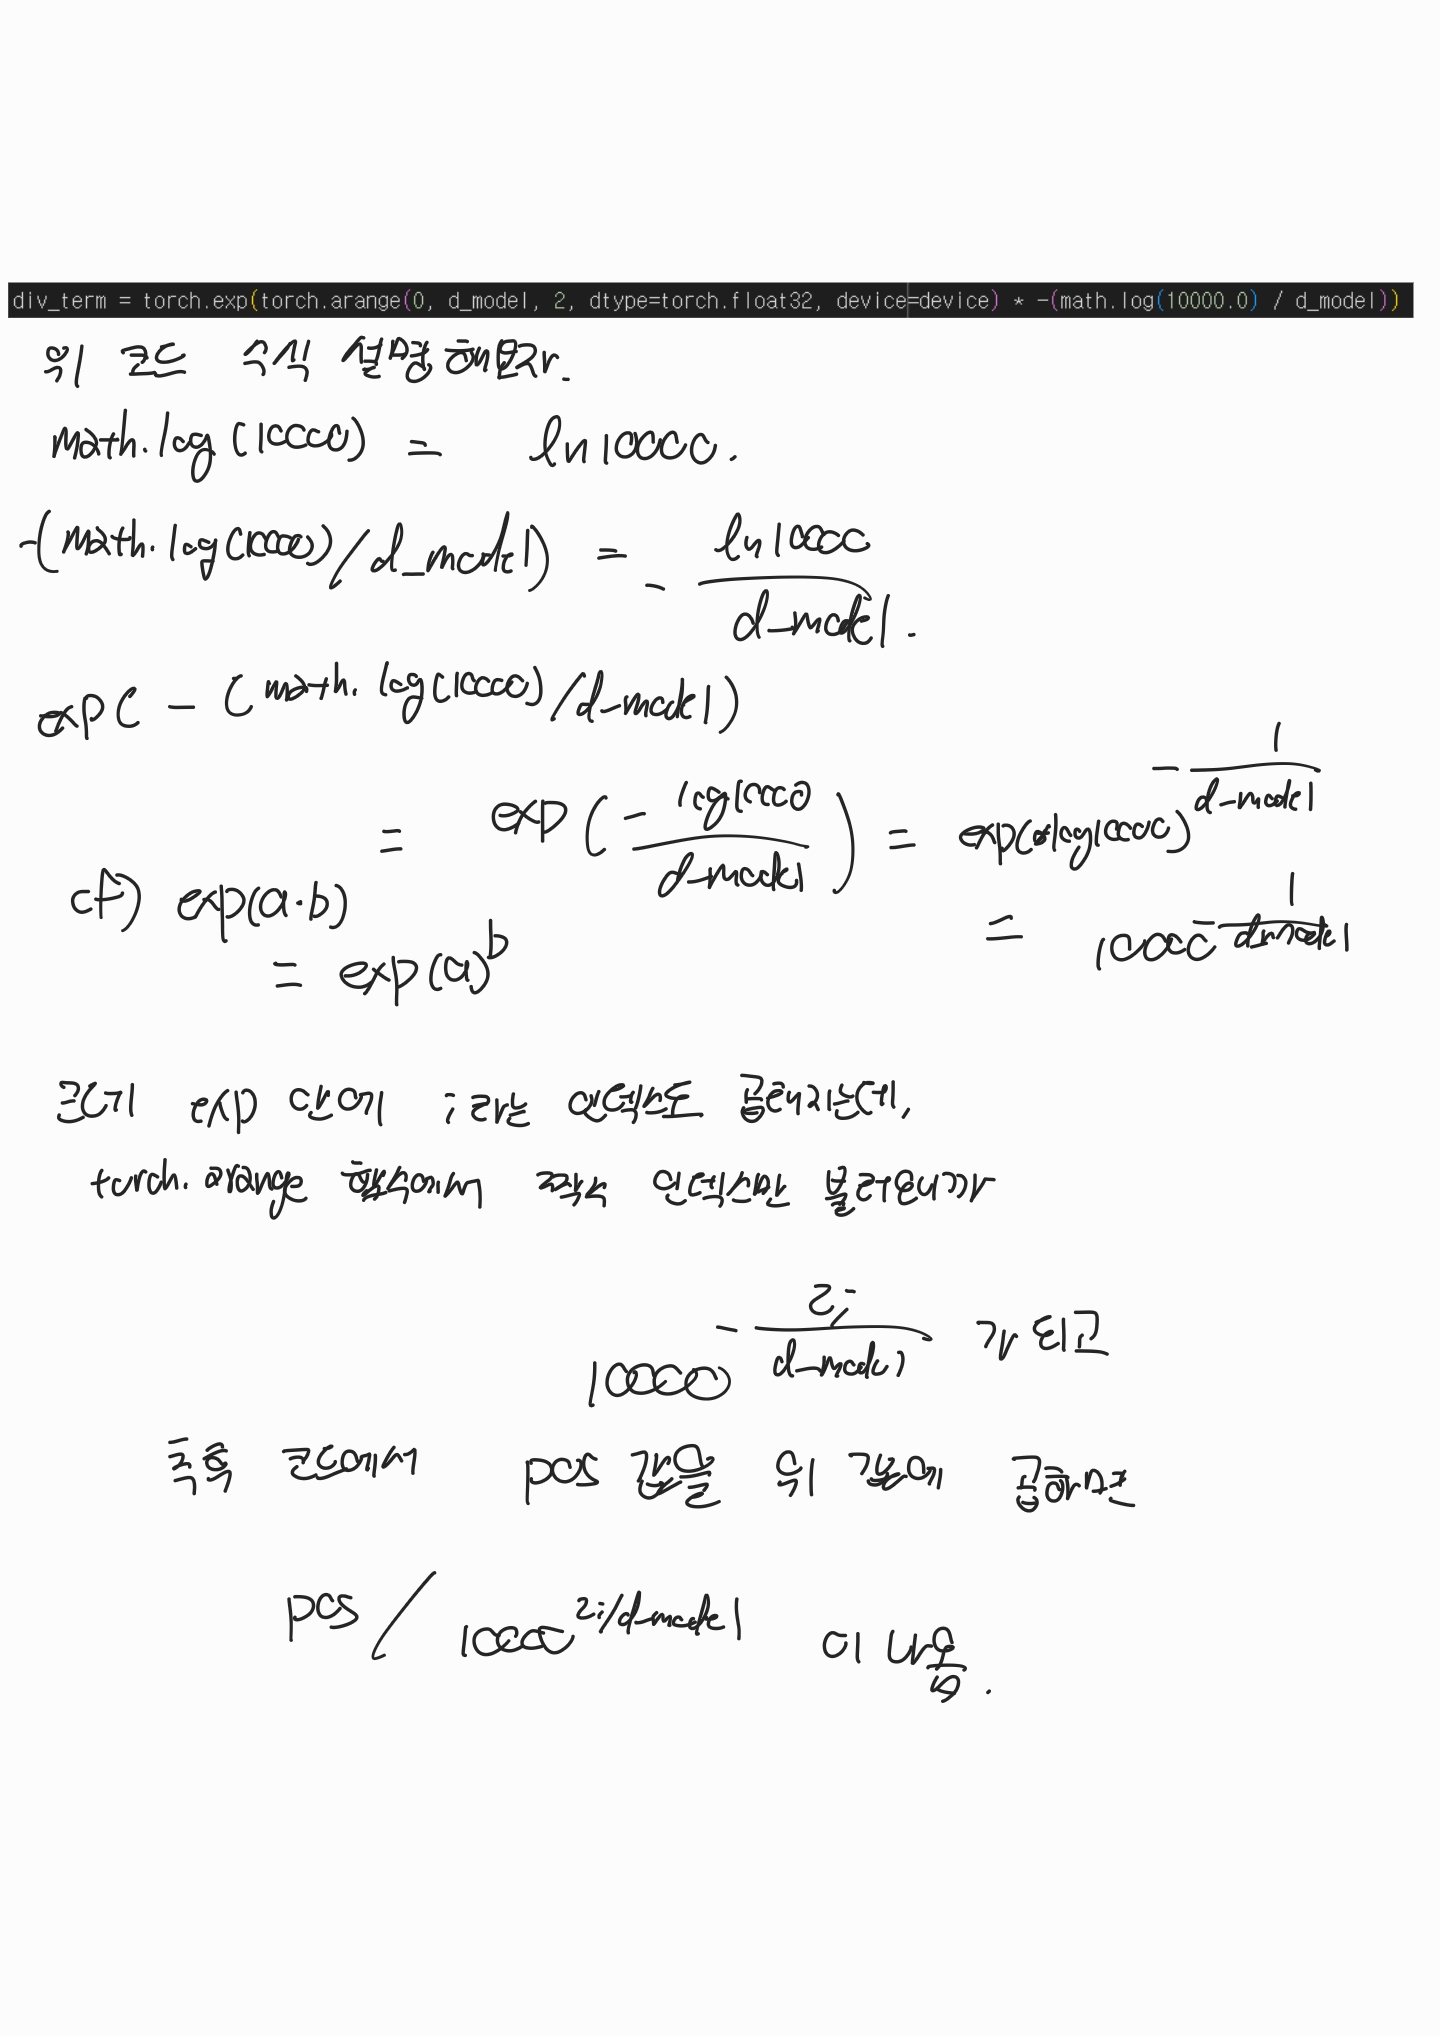

In [ ]:
'''
이 부분은 디코더 및 트랜스포머 부분 정의
Multi-head Self-attention은 위에서 정의 완료
Add & Norm 도 위에서 정의 완료
Position-wise FFNN도 위에서 정의 완료
'''
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
class Emb_Pos_enc_Look_ahead_Mask(nn.Module):
  def __init__(self, d_model, tar_vocab_size):
    super(Emb_Pos_enc_Look_ahead_Mask, self).__init__()
    self.d_model = d_model
    self.embedding = nn.Embedding(tar_vocab_size, d_model, padding_idx=0)

  def embedding_src(self, src):
    # src.shape == (batch_size, seq_len)
    embedded = self.embedding(src)
    return embedded

  def pos_encoding(self, batch_size, seq_len, device):
    d_model = self.d_model

    # 위치 값 (0, 1, 2, ..., seq_len-1) 생성
    positions = torch.arange(seq_len, dtype=torch.float32, device=device).unsqueeze(1)  # (seq_len, 1)

    # 각 차원에 대한 인덱스 (0, 1, 2, ..., d_model/2-1) 생성
    div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32, device=device) * -(math.log(10000.0) / d_model))

    # Positional Encoding을 sin, cos 함수로 계산 (벡터화)
    pe = torch.zeros(seq_len, d_model, dtype=torch.float32, device=device)
    pe[:, 0::2] = torch.sin(positions * div_term)  # 짝수 인덱스에는 sin 함수 적용
    pe[:, 1::2] = torch.cos(positions * div_term)  # 홀수 인덱스에는 cos 함수 적용

    # 배치 크기만큼 확장
    pe = pe.unsqueeze(0).repeat(batch_size, 1, 1)  # (batch_size, seq_len, d_model)

    return pe

  def look_ahead_mask(self, dec_src):
    # src.shape == (batch_size, seq_len)
    batch_size = dec_src.shape[0]
    seq_len_dec = dec_src.shape[1]
    # 아래 코드를 통해 상삼각 행렬로 mask가 구성됨
    # True 인 부분에 마스크를 씌워주면 됨
    look_ahead_mask = torch.triu(torch.ones((seq_len_dec, seq_len_dec)),diagonal=1).to(device).bool()
    # look_ahead_mask.shape == (batch_size, seq_len_dec, seq_len_enc)
    look_ahead_mask = look_ahead_mask.unsqueeze(0).repeat(batch_size, 1,1)
    return look_ahead_mask

  def forward(self, dec_src):
    # 여기선 x가 src
    batch_size = dec_src.shape[0] # batch_size는 아무거나 상관 없음
    seq_len_dec = dec_src.shape[1]
    embedded = self.embedding_src(dec_src) # embedded.shape == (batch_size, seq_len_dec, d_model)
    res = embedded + self.pos_encoding(batch_size, seq_len_dec, dec_src.device)
    mask_ = self.look_ahead_mask(dec_src)
    return res, mask_ # res는 inputs로 들어가게 됨.

class Multi_head_Attention(nn.Module):
  # Query : 디코더 행렬, Key, Value : 인코더 행렬
  def __init__(self, d_model, num_heads):
    super(Multi_head_Attention, self).__init__()
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    self.W_Q = nn.Linear(d_model, d_model, dtype=torch.float32) # Weight 구현
    self.W_K = nn.Linear(d_model, d_model, dtype=torch.float32)
    self.W_V = nn.Linear(d_model, d_model, dtype=torch.float32)

    self.W_O = nn.Linear(d_model, d_model, dtype=torch.float32)

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, encoder_outputs, decoder_inputs):
    batch_size = decoder_inputs.size(0)
    seq_len_dec = decoder_inputs.size(1)
    seq_len_enc = encoder_outputs.size(1)

    W_Q = self.W_Q(decoder_inputs) # W_Q.shape == (batch_size, seq_len, d_model)
    W_K = self.W_K(encoder_outputs)
    W_V = self.W_V(encoder_outputs)

    # W_Q.shape == (batch_size, seq_len, d_k) -> (batch_size, num_heads, seq_len_dec, d_k)
    # W_K.shape == (batch_size, seq_len, d_k) -> (batch_size, num_heads, seq_len_enc, d_k)
    #print(W_Q.shape)
    W_Q = W_Q.view(batch_size, seq_len_dec, self.num_heads, self.d_k).transpose(1,2)
    W_K = W_K.view(batch_size, seq_len_enc, self.num_heads, self.d_k).transpose(1,2)
    W_V = W_V.view(batch_size, seq_len_enc, self.num_heads, self.d_k).transpose(1,2)

    # attention_matrix.shape == (batch_size,num_heads, seq_len_dec, seq_len_enc)
    # 여기선 각 헤드별 attention_matrix를 구한 것
    attention_matrix = torch.matmul(W_Q, W_K.transpose(-2,-1)) / math.sqrt(self.d_k)

    # res.shape == (batch_size, num_heads, seq_len_dec, seq_len_enc)
    res = self.softmax(attention_matrix)
    res = torch.matmul(res, W_V)
    # res.shape == (batch_size, num_heads, seq_len_dec, d_k) ->
    # (batch_size, seq_len_dec, num_heads, d_k) ->
    # (batch_size, seq_len_dec, d_model)
    res = res.transpose(1,2).contiguous().view(batch_size, seq_len_dec, self.d_model)

    # 5. Final projection
    res = self.W_O(res) # (batch_size, seq_len_dec, d_model)

    return res

class DecoderLayer(nn.Module):
  def __init__(self, MultiHeadSelfAttention, Multi_head_Attention, Add_Norm, Position_wise_FFNN, d_model, num_heads, d_ff):
    super(DecoderLayer, self).__init__()
    self.multi_head_self_attention = MultiHeadSelfAttention(d_model, num_heads)
    self.multi_head_attention = Multi_head_Attention(d_model, num_heads)
    self.add_norm = Add_Norm(d_model)
    self.position_wise_ffnn = Position_wise_FFNN(d_model, d_ff)

  def forward(self, encoder_outputs, res_1, mask_):
    # 1. Masked Multi-Head Self Attention
    res_2 = self.multi_head_self_attention(res_1, mask_)
    res_3 = self.add_norm(res_2, res_1)

    # 2. Cross Attention (Decoder Query, Encoder Key/Value)
    res_4 = self.multi_head_attention(encoder_outputs, res_3)
    res_5 = self.add_norm(res_4, res_3)

    # 3. Position-wise Feed Forward Network
    res_6 = self.position_wise_ffnn(res_5)
    res_7 = self.add_norm(res_6, res_5)

    return res_7

class Decoder(nn.Module):
  def __init__(self,
               Emb_Pos_enc_Look_ahead_Mask,
               MultiHeadSelfAttention,
               Add_Norm,
               Position_wise_FFNN,
               Multi_head_Attention,
               DecoderLayer,
               num_layers,
               d_model,
               num_heads,
               d_ff,
               src_vocab_size,
               tar_vocab_size):
    super(Decoder, self).__init__()
    self.emb_pos_enc_look_ahead_mask = Emb_Pos_enc_Look_ahead_Mask(d_model, tar_vocab_size)
    self.layers = nn.ModuleList([
        DecoderLayer(MultiHeadSelfAttention, Multi_head_Attention, Add_Norm, Position_wise_FFNN, d_model, num_heads, d_ff) for _ in range(num_layers)
    ])
    self.linear = nn.Linear(d_model, tar_vocab_size)


  def forward(self, dec_src, encoder_outputs):
    res, mask_ = self.emb_pos_enc_look_ahead_mask(dec_src)
    for layer in self.layers:
      res = layer(encoder_outputs, res, mask_)
    # res.shape == (batch_size, seq_len, d_model)
    res = self.linear(res)
    # res.shape == (batch_size, seq_len, tar_vocab_size)
    return res

'''
nn.CrossEntropyLoss 함수를 손실함수로 사용할 것인데,
이 안에 nn.softmax가 내장되어 있어서 Transformer output에는 안 써도 됨.
추론할 때:
-> 필요하면 따로 F.softmax(output, dim=-1) 해서 확률로 변환해 쓰면 된다.
'''

class Transformer(nn.Module):
  def __init__(self,
               Emb_Pos_enc_Mask,
               Emb_Pos_enc_Look_ahead_Mask,
               MultiHeadSelfAttention,
               Multi_head_Attention,
               Add_Norm,
               Position_wise_FFNN,
               EncoderLayer,
               DecoderLayer,
               Encoder,
               Decoder,
               num_layers,
               d_model,
               num_heads,
               d_ff,
               src_vocab_size,
               tar_vocab_size):
    super(Transformer, self).__init__()
    self.encoder = Encoder(Emb_Pos_enc_Mask, MultiHeadSelfAttention, Add_Norm, Position_wise_FFNN, EncoderLayer, num_layers, d_model, num_heads, d_ff, src_vocab_size)
    self.decoder = Decoder(Emb_Pos_enc_Look_ahead_Mask,
                           MultiHeadSelfAttention,
                           Add_Norm,
                           Position_wise_FFNN,
                           Multi_head_Attention,
                           DecoderLayer,
                           num_layers,
                           d_model,
                           num_heads,
                           d_ff,
                           src_vocab_size,
                           tar_vocab_size)

  def forward(self, encoder_src, decoder_src):
    encoder_outputs = self.encoder(encoder_src)
    decoder_outputs = self.decoder(decoder_src, encoder_outputs)
    return decoder_outputs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# 주요 하이퍼파라미터 정의
d_model = 512 # 임베딩 벡터의 차원, 피드 포워드 신경망의 입력층의 차원과 출력층의 크기
num_layers = 6 # 인코더와 디코더 레이어의 층 수
num_heads = 8 # 병렬 어텐션의 수
d_ff = 2048 # 피드 포워드 은닉층의 수

# 모델 선언
model_self_transformer = Transformer(
    Emb_Pos_enc_Mask,
    Emb_Pos_enc_Look_ahead_Mask,
    MultiHeadSelfAttention,
    Multi_head_Attention,
    Add_Norm,
    Position_wise_FFNN,
    EncoderLayer,
    DecoderLayer,
    Encoder,
    Decoder,
    num_layers,
    d_model,
    num_heads,
    d_ff,
    src_vocab_size,
    tar_vocab_size
)

In [ ]:
print(model_self_transformer) # 모델 구조 출력

Transformer(
  (encoder): Encoder(
    (emb_pos_enc_mask): Emb_Pos_enc_Mask(
      (embedding): Embedding(4498, 512, padding_idx=0)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (multi_head_self_attention): MultiHeadSelfAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
          (softmax): Softmax(dim=-1)
        )
        (add_norm): Add_Norm(
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (position_wise_ffnn): Position_wise_FFNN(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
        )
      )
    )
  )
  (decoder): Decoder(
    (emb_pos_enc_look_

In [ ]:
# 평가 함수 작성. 해당 함수는 이전에 사용한 evaluation을 이용
def evaluation(model, dataloader, loss_function, device):
  model.eval()
  total_loss = 0.0
  total_cnt = 0
  total_correct = 0

  with torch.no_grad():
    for encoder_inputs, decoder_inputs, decoder_targets in dataloader:

      encoder_inputs = encoder_inputs.to(device)
      decoder_inputs = decoder_inputs.to(device)
      decoder_targets = decoder_targets.to(device)

      # 순방향 전파
      # outputs.shape == (batch_size, seq_len, tar_vocab_size)
      outputs = model(encoder_inputs, decoder_inputs)

      # 손실 계산
      # decoder_targerts.view(-1).shape == (batch_size * seq_len)
      # outputs.view(-1, outputs.size(-1)).shape == (batch_size, seq_len, tar_vocab_size)
      # nn.CrossEntropyLoss 는 (output, label) 형태로 입력을 받는데,
      # output은 (N, C), label은 (N) 형태여야 함
      # N : 전체 샘플 수, C : 클래스
      # label은 정답 인덱스 하나를 의미
      loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
      total_loss += loss.item()

      # 정확도 계산, 패딩 토큰 제외
      # item은 파이토치 텐서가 아니라 int로 받아줌
      mask = decoder_targets != 0
      total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
      total_cnt += mask.sum().item()

  # loss와 정확도 리턴
  return total_loss / len(dataloader), total_correct / total_cnt

In [ ]:
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model_self_transformer.parameters(), lr=0.0003)

In [ ]:
'''
각각의 데이터를 파이토치 텐서로 변환하고 배치 크기가 128인 데이터로더로 변환한다.
그 후, 학습 에포크를 먼저 35로 두자.
'''
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype = torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype = torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype = torch.long)

encoder_input_test_tensor = torch.tensor(encoder_input_test, dtype = torch.long)
decoder_input_test_tensor = torch.tensor(decoder_input_test, dtype = torch.long)
decoder_target_test_tensor = torch.tensor(decoder_target_test, dtype = torch.long)

# 데이터셋 및 데이터로더 설정
batch_size = 128

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

# valid 에 shuffle을 하면 어떤 배치냐에 따라서 loss가 들쑥날쑥할 수 있음
valid_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False)

# 학습 설정
num_epochs = 35
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_self_transformer.to(device)

cuda


Transformer(
  (encoder): Encoder(
    (emb_pos_enc_mask): Emb_Pos_enc_Mask(
      (embedding): Embedding(4498, 512, padding_idx=0)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (multi_head_self_attention): MultiHeadSelfAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
          (softmax): Softmax(dim=-1)
        )
        (add_norm): Add_Norm(
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (position_wise_ffnn): Position_wise_FFNN(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
        )
      )
    )
  )
  (decoder): Decoder(
    (emb_pos_enc_look_

In [ ]:
print(device)
print(decoder_target_train_tensor.shape)
print(decoder_input_train_tensor.shape)
print(encoder_input_train_tensor.shape)

cuda
torch.Size([29700, 16])
torch.Size([29700, 16])
torch.Size([29700, 7])


In [ ]:
print(encoder_input_train_tensor[0])
print(decoder_input_train_tensor[0])
print(decoder_target_train_tensor[0])

tensor([ 20, 204, 504,   2,   0,   0,   0])
tensor([  3,  14, 188, 107, 591,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])
tensor([ 14, 188, 107, 591,   2,   4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])


In [ ]:
'''
모델 훈련
'''
from tqdm import tqdm

best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
  # 훈련 모드
  model_self_transformer.train()

  for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
    encoder_inputs = encoder_inputs.to(device)
    decoder_inputs = decoder_inputs.to(device)
    decoder_targets = decoder_targets.to(device)

    # 기울기 초기화
    optimizer.zero_grad()

    # 순방향 전파
    # outputs.shape == (batch_size, seq_len, tar_vocab_size)
    outputs = model_self_transformer(encoder_inputs, decoder_inputs)

    # 손실 계산 및 역방향 전파
    # loss 는 위의 evaluation에서 사용한 부분과 동일
    # 여기서는 미니 배치마다 구하는 것이니 += 가 아닌 = 사용
    # 한 배치가 끝나고 loss를 더하면 됨
    loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
    # 역방향 전파
    loss.backward()
    # 가중치 업데이트
    optimizer.step()
    #scheduler.step()  # <-- batch마다 호출

  train_loss, train_acc = evaluation(model_self_transformer, train_dataloader, loss_function, device)
  valid_loss, valid_acc = evaluation(model_self_transformer, valid_dataloader, loss_function, device)

  print(f'Epoch : {epoch+1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train Accuracy : {train_acc:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid Accuracy : {valid_acc:.4f}')

  # 검증 손실이 최소일 때 체크포인트 저장
  if valid_loss < best_val_loss:
    print(f'Valid loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('체크 포인트를 저장합니다.')
    best_val_loss = valid_loss
    torch.save(model_self_transformer.state_dict(), 'best_transformer_checkpoint.pth')

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch : 1 / 35
Train Loss : 2.1738 | Train Accuracy : 0.6200
Valid Loss : 2.2875 | Valid Accuracy : 0.6166
Valid loss improved from inf to 2.2875
체크 포인트를 저장합니다.


  3%|▎         | 1/35 [01:00<34:10, 60.30s/it]

Epoch : 2 / 35
Train Loss : 1.2936 | Train Accuracy : 0.7418
Valid Loss : 1.6083 | Valid Accuracy : 0.7078
Valid loss improved from 2.2875 to 1.6083
체크 포인트를 저장합니다.


  6%|▌         | 2/35 [02:01<33:26, 60.81s/it]

Epoch : 3 / 35
Train Loss : 0.8273 | Train Accuracy : 0.8148
Valid Loss : 1.3064 | Valid Accuracy : 0.7460
Valid loss improved from 1.6083 to 1.3064
체크 포인트를 저장합니다.


  9%|▊         | 3/35 [03:02<32:28, 60.89s/it]

Epoch : 4 / 35
Train Loss : 0.6241 | Train Accuracy : 0.8415
Valid Loss : 1.2374 | Valid Accuracy : 0.7490
Valid loss improved from 1.3064 to 1.2374
체크 포인트를 저장합니다.


 11%|█▏        | 4/35 [04:03<31:28, 60.91s/it]

Epoch : 5 / 35
Train Loss : 0.4414 | Train Accuracy : 0.8760
Valid Loss : 1.1402 | Valid Accuracy : 0.7682
Valid loss improved from 1.2374 to 1.1402
체크 포인트를 저장합니다.


 17%|█▋        | 6/35 [06:04<29:16, 60.57s/it]

Epoch : 6 / 35
Train Loss : 0.3936 | Train Accuracy : 0.8781
Valid Loss : 1.1521 | Valid Accuracy : 0.7588
Epoch : 7 / 35
Train Loss : 0.3121 | Train Accuracy : 0.9011
Valid Loss : 1.1299 | Valid Accuracy : 0.7739
Valid loss improved from 1.1402 to 1.1299
체크 포인트를 저장합니다.


 23%|██▎       | 8/35 [08:04<27:12, 60.45s/it]

Epoch : 8 / 35
Train Loss : 0.3328 | Train Accuracy : 0.8997
Valid Loss : 1.1971 | Valid Accuracy : 0.7619


 26%|██▌       | 9/35 [09:04<26:08, 60.31s/it]

Epoch : 9 / 35
Train Loss : 0.2705 | Train Accuracy : 0.9091
Valid Loss : 1.1474 | Valid Accuracy : 0.7742


 29%|██▊       | 10/35 [10:05<25:06, 60.25s/it]

Epoch : 10 / 35
Train Loss : 0.2513 | Train Accuracy : 0.9148
Valid Loss : 1.1504 | Valid Accuracy : 0.7745


 31%|███▏      | 11/35 [11:05<24:04, 60.18s/it]

Epoch : 11 / 35
Train Loss : 0.2368 | Train Accuracy : 0.9166
Valid Loss : 1.1433 | Valid Accuracy : 0.7764


 34%|███▍      | 12/35 [12:05<23:03, 60.16s/it]

Epoch : 12 / 35
Train Loss : 0.2322 | Train Accuracy : 0.9183
Valid Loss : 1.1735 | Valid Accuracy : 0.7727


 37%|███▋      | 13/35 [13:05<22:01, 60.05s/it]

Epoch : 13 / 35
Train Loss : 0.2504 | Train Accuracy : 0.9143
Valid Loss : 1.2088 | Valid Accuracy : 0.7682


 40%|████      | 14/35 [14:04<20:59, 59.97s/it]

Epoch : 14 / 35
Train Loss : 0.2472 | Train Accuracy : 0.9137
Valid Loss : 1.2105 | Valid Accuracy : 0.7667


 43%|████▎     | 15/35 [15:04<19:57, 59.89s/it]

Epoch : 15 / 35
Train Loss : 0.2747 | Train Accuracy : 0.9085
Valid Loss : 1.2361 | Valid Accuracy : 0.7612


 46%|████▌     | 16/35 [16:05<19:01, 60.08s/it]

Epoch : 16 / 35
Train Loss : 0.2307 | Train Accuracy : 0.9177
Valid Loss : 1.1962 | Valid Accuracy : 0.7716


 49%|████▊     | 17/35 [17:04<18:00, 60.04s/it]

Epoch : 17 / 35
Train Loss : 0.2102 | Train Accuracy : 0.9221
Valid Loss : 1.2130 | Valid Accuracy : 0.7764


 51%|█████▏    | 18/35 [18:04<17:00, 60.03s/it]

Epoch : 18 / 35
Train Loss : 0.2033 | Train Accuracy : 0.9234
Valid Loss : 1.2092 | Valid Accuracy : 0.7729


 54%|█████▍    | 19/35 [19:04<16:00, 60.01s/it]

Epoch : 19 / 35
Train Loss : 0.2021 | Train Accuracy : 0.9246
Valid Loss : 1.2166 | Valid Accuracy : 0.7752


 57%|█████▋    | 20/35 [20:05<15:01, 60.12s/it]

Epoch : 20 / 35
Train Loss : 0.1927 | Train Accuracy : 0.9262
Valid Loss : 1.2264 | Valid Accuracy : 0.7723


 60%|██████    | 21/35 [21:05<14:01, 60.11s/it]

Epoch : 21 / 35
Train Loss : 0.1980 | Train Accuracy : 0.9247
Valid Loss : 1.2318 | Valid Accuracy : 0.7722


 63%|██████▎   | 22/35 [22:05<13:00, 60.04s/it]

Epoch : 22 / 35
Train Loss : 0.2046 | Train Accuracy : 0.9223
Valid Loss : 1.2257 | Valid Accuracy : 0.7708


 66%|██████▌   | 23/35 [23:05<11:59, 59.96s/it]

Epoch : 23 / 35
Train Loss : 0.2015 | Train Accuracy : 0.9228
Valid Loss : 1.2382 | Valid Accuracy : 0.7716


 69%|██████▊   | 24/35 [24:05<11:00, 60.02s/it]

Epoch : 24 / 35
Train Loss : 0.2077 | Train Accuracy : 0.9216
Valid Loss : 1.2497 | Valid Accuracy : 0.7681


 71%|███████▏  | 25/35 [25:05<10:00, 60.01s/it]

Epoch : 25 / 35
Train Loss : 0.2023 | Train Accuracy : 0.9232
Valid Loss : 1.2692 | Valid Accuracy : 0.7712


 74%|███████▍  | 26/35 [26:04<08:59, 59.94s/it]

Epoch : 26 / 35
Train Loss : 0.2022 | Train Accuracy : 0.9211
Valid Loss : 1.2631 | Valid Accuracy : 0.7721


 77%|███████▋  | 27/35 [27:04<07:59, 59.90s/it]

Epoch : 27 / 35
Train Loss : 0.2394 | Train Accuracy : 0.9136
Valid Loss : 1.3041 | Valid Accuracy : 0.7568


 80%|████████  | 28/35 [28:04<06:59, 59.94s/it]

Epoch : 28 / 35
Train Loss : 0.1903 | Train Accuracy : 0.9248
Valid Loss : 1.2614 | Valid Accuracy : 0.7743


 83%|████████▎ | 29/35 [29:05<06:00, 60.03s/it]

Epoch : 29 / 35
Train Loss : 0.1810 | Train Accuracy : 0.9267
Valid Loss : 1.2816 | Valid Accuracy : 0.7759


 86%|████████▌ | 30/35 [30:04<04:59, 59.95s/it]

Epoch : 30 / 35
Train Loss : 0.1773 | Train Accuracy : 0.9275
Valid Loss : 1.2952 | Valid Accuracy : 0.7746


 89%|████████▊ | 31/35 [31:04<03:59, 59.86s/it]

Epoch : 31 / 35
Train Loss : 0.1817 | Train Accuracy : 0.9259
Valid Loss : 1.2838 | Valid Accuracy : 0.7746


 91%|█████████▏| 32/35 [32:04<02:59, 59.85s/it]

Epoch : 32 / 35
Train Loss : 0.1773 | Train Accuracy : 0.9269
Valid Loss : 1.2967 | Valid Accuracy : 0.7754


 94%|█████████▍| 33/35 [33:04<01:59, 59.86s/it]

Epoch : 33 / 35
Train Loss : 0.1749 | Train Accuracy : 0.9278
Valid Loss : 1.3109 | Valid Accuracy : 0.7737


 97%|█████████▋| 34/35 [34:03<00:59, 59.83s/it]

Epoch : 34 / 35
Train Loss : 0.1835 | Train Accuracy : 0.9242
Valid Loss : 1.2990 | Valid Accuracy : 0.7696


100%|██████████| 35/35 [35:03<00:00, 60.11s/it]

Epoch : 35 / 35
Train Loss : 0.1947 | Train Accuracy : 0.9216
Valid Loss : 1.2994 | Valid Accuracy : 0.7668


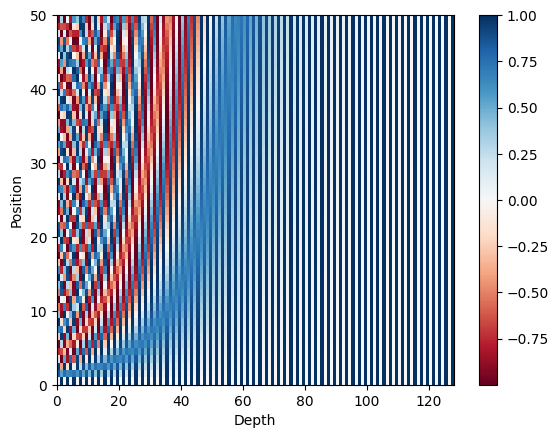

In [ ]:
# 내부 부품들 test
# 1. positional Encoding
import matplotlib.pyplot as plt
def pos_encoding(src_vocab_size, d_model):
  PE = np.zeros([src_vocab_size, d_model])
  for pos in range(src_vocab_size):
    for i in range(0,d_model-1,2):
      PE[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
      PE[pos][i+1] = np.cos(pos / (10000 ** (i / d_model)))

  return PE

sample_pos_encoding = pos_encoding(50, 128)

plt.pcolormesh(sample_pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
'''
Attention 보다 성능이 좋음
검증 데이터 손실이 최소일 때의 모델을 로드하고 다시 재평가
'''

# 모델 로드
model_self_transformer.load_state_dict(torch.load('best_transformer_checkpoint.pth'))

# 모델을 device에 올림
model_self_transformer.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluation(model_self_transformer, valid_dataloader, loss_function, device)

print(f'Best model validation loss : {val_loss:.4f}')
print(f'Best model validation accuracy : {val_accuracy:.4f}')

Best model validation loss : 1.1299
Best model validation accuracy : 0.7739


In [ ]:
print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])

3
4


In [ ]:
'''
기계 번역기 동작 시키기
Transformer 역시 훈련과정에서는 교사 강요를 사용하고 테스트 과정에서의 동작 방식이 다름
그래서 테스트 과정을 위해 모델을 다시 설계해주어야 함
특히 디코더 부분을 수정해야 함
이번에는 번역 단계를 위해 모델을 수정하고 동작시킴

전체적인 번역 단계를 정리하면 다음과 같다.

1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻음
2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos> 를 디코더로 보냄
3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복

결과 확인을 위한 함수를 만듦
seq_to_src 함수는 영어 문장에 해당하는 정수 시퀀스를 입력 받으면 정수로부터 영어 단어를 리턴하는
index_to_src를 통해 영어 문장으로 변환
seq_to_tar은 프랑스어에 해당하는 정수 시퀀스를 입력 받으면 정수로부터
프랑스어 단어를 리턴하는 index_to_tar을 통해 프랑스어 문장으로 변환
'''

index_to_src = {v : k for k, v in src_vocab.items()}
index_to_tar = {v : k for k, v in tar_vocab.items()}

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if encoded_word != 0:
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']:
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, int_to_src_token, int_to_tar_token, max_output_len=5000):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
    encoder_outputs = model.encoder(encoder_inputs)

    # 디코더 첫 입력: <sos> 토큰 (3)
    decoded_tokens = [3]  # 디코더 입력 저장하는 리스트

    for _ in range(max_output_len):
        # 현재까지 예측한 토큰들을 디코더 인풋으로 사용
        # unsqueeze를 사용하여 배치 차원을 맞춰 줌
        decoder_inputs = torch.tensor(decoded_tokens, dtype=torch.long, device=device).unsqueeze(0)

        # 디코더 통과
        output = model.decoder(decoder_inputs, encoder_outputs)

        # 마지막 토큰 위치에 대해 argmax
        output_token = output[0, -1].argmax(dim=-1).item()

        # 종료 토큰 <eos> (4) 만나면 중단
        if output_token == 4:
            break

        decoded_tokens.append(output_token)

    # 디코딩 결과 (맨 앞 <sos> 제외)
    return ' '.join(int_to_tar_token[token] for token in decoded_tokens[1:])

In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index]
  translated_text = decode_sequence(input_seq, model_self_transformer, src_vocab_size, tar_vocab_size, index_to_src, index_to_tar, 5000)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)

입력문장 : i hate to wait . 
정답문장 : je deteste attendre . 
번역문장 : je deteste attendre .
--------------------------------------------------
입력문장 : i like it hot . 
정답문장 : je l aime chaud . 
번역문장 : je l aime chaud .
--------------------------------------------------
입력문장 : you re stalling . 
정답문장 : vous temporisez . 
번역문장 : vous temporisez .
--------------------------------------------------
입력문장 : you re my guests . 
정답문장 : vous etes mes invites . 
번역문장 : vous etes mes invites .
--------------------------------------------------
입력문장 : are you home ? 
정답문장 : es tu a la maison ? 
번역문장 : es tu a la maison ?
--------------------------------------------------


In [ ]:
# 테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력해보자
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model_self_transformer, src_vocab_size, tar_vocab_size, index_to_src, index_to_tar, 5000)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)

입력문장 : i was speaking . 
정답문장 : j etais en train de parler . 
번역문장 : j etais en train de parler .
--------------------------------------------------
입력문장 : you go first . 
정답문장 : je vous en prie . 
번역문장 : vas y d abord .
--------------------------------------------------
입력문장 : will you go too ? 
정답문장 : iras tu aussi ? 
번역문장 : iras tu aussi ?
--------------------------------------------------
입력문장 : i love to cook . 
정답문장 : j aime cuisiner . 
번역문장 : j adore cuisiner .
--------------------------------------------------
입력문장 : you re too loud . 
정답문장 : vous etes trop bruyant . 
번역문장 : vous etes trop fort .
--------------------------------------------------
